# Explanation vs Prediction

In this notebook, we start with the philosophical argument that explanatory modeling is a fundamentally different exercise with a different goal from predictive modeling. Explanatory models are meant to discover the narratives of outcomes (looking backwards to the past) while predictive models are meant to `best guess` outcomes (looking forwards to the future). We might as well add that causal modeling is different from both as well, as causal models are meant to discover how to `change` outcomes. 

Typically, for a probabilistic classifier, the Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC) and Precision-Recall (PR) curves are used to judge the performance of such a classifier. AUC-ROC is more dominant in the certain fields, but AUC-PR is more appropriate when there is class imbalance with the data. These performance measures are entirely appropriate when used in predictive modeling as you want to see if a model can generalize into the future on unseen data. 

Sometimes, probabilistic classifiers are learned for explanatory purpose, and prediction is a secondary concern, if at all. Common approaches to building models for explanatory purpose often involves stepwise, greedy search for features to add that will improve the model. A usual performance measure to test if a feature/variable should be added includes computing the likelihood of the model (eg. $P(D|M)$ where $D$ is the data and $M$ is the model). Computing the likelihood of a model may be intractable, however. Another way to judge a model is to use something like r-squared. At heart, r-squared compares the lift of the alternative model with a reference (or null) model. Although not identical to r-squared, a host of pseudo r-squared have been invented for logistic regression. We can reason that if we find an r-squared like measure to judge a probabilistic classifier, we can use such measure the explanatory performance of the model. 

Proper scoring rules like the Brier Score (BS) are wholly appropriate to judge probabilistic classifiers (even more than quasi-proper and improper scoring rules). [It is said](https://en.wikipedia.org/wiki/Brier_score) that the BS is to the Brier Skill Score (BSS) as Mean Squared Error (MSE) is to r-squared. We argue that you can use the BSS for model selection in choosing among different explanatory models. We show how to do so in this notebook, including how choosing an optimal explantory model may mean choosing a sub-optimal predictive model (and vice-versa).

## Load data

Let's import a dataset about students and whether they have conducted research. The indepent variables in X are the student's scores and peformance measures, and the dependent variable y is whether they have done research (y = 1) or not (y = 0).

In [1]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/selva86/datasets/master/Admission.csv'
Xy = pd.read_csv(url) \
    .drop(columns=['Chance of Admit ', 'Serial No.'])
    
X = Xy.drop(columns=['Research'])
y = Xy['Research']

X.shape, y.shape

((400, 6), (400,))

## Split data

Here, we split the data into 10% testing and 90% training while preserving the proportion of y in both folds.

In [87]:
from sklearn.model_selection import StratifiedKFold

tr_idx, te_idx = next(StratifiedKFold(n_splits=10, random_state=37, shuffle=True).split(X, y))

X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((360, 6), (360,), (40, 6), (40,))

In [88]:
y_tr.value_counts() / y_tr.value_counts().sum()

Research
1    0.547222
0    0.452778
Name: count, dtype: float64

In [89]:
y_te.value_counts() / y_te.value_counts().sum()

Research
1    0.55
0    0.45
Name: count, dtype: float64

## Model

To start off, we will model the data using a logistic regression model. All the features will be used, and so we will call this model a saturated one.

In [5]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression(n_jobs=-1, random_state=37, solver='saga', max_iter=10_000)
m.fit(X_tr, y_tr)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=37, solver='saga')

## Score

Now let's look at some scores for the null and saturated models.

- roc: AUC-ROC
- aps: AUC-PR
- brier: BS
- log: log loss

### Null model

Clearly below, you can see that the null model has no predictive power since AUC-ROC is no better than chance (50%) and AUC-PR is also no better than chance (the average percision score is equal to the climatic average). With the BS and log loss score, lower is better, but we have no idea if these are good are bad since we have no other model to compare with, yet. 

In [90]:
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, log_loss

p1 = (y_tr.value_counts() / y_tr.value_counts().sum()).sort_index().loc[1]
y_pred = np.full(y_te.shape, p1)

pd.Series([
    roc_auc_score(y_te, y_pred), 
    average_precision_score(y_te, y_pred),
    brier_score_loss(y_te, y_pred),
    log_loss(y_te, y_pred)
], ['roc', 'aps', 'brier', 'log'])

roc      0.500000
aps      0.550000
brier    0.247508
log      0.688154
dtype: float64

### Saturated model

The saturated model is definitely doing better than chance at predicting as indicated by AUC-ROC and AUC-PR. We see that both BS and log loss score are also lower, and so the saturateed model better explains the the variance we see in the data.

In [14]:
y_pred = m.predict_proba(X_te)[:,1]

pd.Series([
    roc_auc_score(y_te, y_pred), 
    average_precision_score(y_te, y_pred),
    brier_score_loss(y_te, y_pred),
    log_loss(y_te, y_pred)
], ['roc', 'aps', 'brier', 'log'])

roc      0.768246
aps      0.747516
brier    0.194466
log      0.580401
dtype: float64

## Model search

Here, we do a model search. Since there are 6 independent variables, there are $C^6_6 + C^6_5 + C^6_4 + C^6_3 + C^6_2 + C^6_1 = 63$ possible combinations of variables.

In [86]:
import itertools

models = itertools.chain(*[itertools.combinations(X.columns, i) for i in range(1, X.shape[1] + 1)])
models = map(lambda x: list(x), models)
models = list(models)

len(models)

63

For each possible combination of variables, we learn a logistic regression model and compute performance measures.

- roc: AUC-ROC
- aps: AUC-PR
- brier_null: BS for the null model
- brier_pred: BS for the model (of the specified combination of features)
- bss: BSS for the model
- log_null: log loss score for the null model
- log_pred: log loss score for the model
- lss: log loss skill score for the model

In [80]:
def get_performance(columns, X_tr, y_tr, X_te, y_te):
    m = LogisticRegression(n_jobs=-1, random_state=37, solver='saga', max_iter=10_000)
    m.fit(X_tr[columns], y_tr)
    
    p1 = (y_tr.value_counts() / y_tr.value_counts().sum()).sort_index().loc[1]
    y_null = np.full(y_te.shape, p1)    
    y_pred = m.predict_proba(X_te[columns])[:,1]
    
    b_null = brier_score_loss(y_te, y_null)
    b_pred = brier_score_loss(y_te, y_pred)
    bss = 1 - (b_pred / b_null)
    
    l_null = log_loss(y_te, y_null)
    l_pred = log_loss(y_te, y_pred)
    lss = 1 - (l_pred / l_null)

    p = pd.Series([
        roc_auc_score(y_te, y_pred), 
        average_precision_score(y_te, y_pred),
        b_null,
        b_pred,
        bss,
        l_null,
        l_pred,
        lss
    ], ['roc', 'aps', 'brier_null', 'brier_pred', 'bss', 'log_null', 'log_pred', 'lss'])
    
    return p

r = pd.DataFrame({'|'.join(m): get_performance(m, X_tr, y_tr, X_te, y_te) for m in models}).T
r

,roc,aps,brier_null,brier_pred,bss,log_null,log_pred,lss
GRE Score,0.851224,0.870199,0.248012,0.247035,0.003937,0.689166,0.687184,0.002876
TOEFL Score,0.803616,0.830837,0.248012,0.229693,0.073862,0.689166,0.651750,0.054292
University Rating,0.761285,0.752031,0.248012,0.195166,0.213080,0.689166,0.580746,0.157320
SOP,0.762183,0.735531,0.248012,0.194738,0.214804,0.689166,0.581555,0.156146
LOR,0.735010,0.733848,0.248012,0.207188,0.164606,0.689166,0.602331,0.126000
...,...,...,...,...,...,...,...,...
GRE Score|TOEFL Score|University Rating|LOR |CGPA,0.762632,0.768483,0.248012,0.198189,0.200889,0.689166,0.585421,0.150537
GRE Score|TOEFL Score|SOP|LOR |CGPA,0.761060,0.737548,0.248012,0.199990,0.193625,0.689166,0.590588,0.143039
GRE Score|University Rating|SOP|LOR |CGPA,0.773411,0.754668,0.248012,0.192660,0.223183,0.689166,0.576357,0.163689
TOEFL Score|University Rating|SOP|LOR |CGPA,0.770716,0.750870,0.248012,0.193978,0.217868,0.689166,0.581121,0.156776


### Best models, ROC

The best model based on AUC-ROC is the one with a single variable, `GRE Score`.

In [81]:
r.sort_values(['roc'], ascending=False).head(5)

,roc,aps,brier_null,brier_pred,bss,log_null,log_pred,lss
GRE Score,0.851224,0.870199,0.248012,0.247035,0.003937,0.689166,0.687184,0.002876
SOP|CGPA,0.831574,0.854039,0.248012,0.169722,0.315671,0.689166,0.517150,0.249601
CGPA,0.831125,0.857370,0.248012,0.170853,0.311110,0.689166,0.523775,0.239987
SOP|LOR |CGPA,0.830227,0.857736,0.248012,0.171121,0.310029,0.689166,0.519056,0.246834
University Rating|CGPA,0.828543,0.852778,0.248012,0.170621,0.312046,0.689166,0.523330,0.240633


### Best models, APS

The best model based on AUC-PR is also the one with only `GRE Score`.

In [82]:
r.sort_values(['aps'], ascending=False).head(5)

,roc,aps,brier_null,brier_pred,bss,log_null,log_pred,lss
GRE Score,0.851224,0.870199,0.248012,0.247035,0.003937,0.689166,0.687184,0.002876
LOR |CGPA,0.825960,0.858192,0.248012,0.172072,0.306196,0.689166,0.522815,0.241380
SOP|LOR |CGPA,0.830227,0.857736,0.248012,0.171121,0.310029,0.689166,0.519056,0.246834
CGPA,0.831125,0.857370,0.248012,0.170853,0.311110,0.689166,0.523775,0.239987
University Rating|SOP|LOR |CGPA,0.827083,0.854215,0.248012,0.170789,0.311370,0.689166,0.521194,0.243732


### Best models, BSS

Based on BSS, the best model is the one with `University Rating + SOP + CGPA`.

In [83]:
r.sort_values(['bss'], ascending=False).head(5)

,roc,aps,brier_null,brier_pred,bss,log_null,log_pred,lss
University Rating|SOP|CGPA,0.825960,0.847663,0.248012,0.169691,0.315796,0.689166,0.519701,0.245898
SOP|CGPA,0.831574,0.854039,0.248012,0.169722,0.315671,0.689166,0.517150,0.249601
University Rating|CGPA,0.828543,0.852778,0.248012,0.170621,0.312046,0.689166,0.523330,0.240633
University Rating|SOP|LOR |CGPA,0.827083,0.854215,0.248012,0.170789,0.311370,0.689166,0.521194,0.243732
CGPA,0.831125,0.857370,0.248012,0.170853,0.311110,0.689166,0.523775,0.239987


### Best model, LSS

Based on LSS, the best model is the one with `SOP + CGPA`.

In [84]:
r.sort_values(['lss'], ascending=False).head(5)

,roc,aps,brier_null,brier_pred,bss,log_null,log_pred,lss
SOP|CGPA,0.831574,0.854039,0.248012,0.169722,0.315671,0.689166,0.517150,0.249601
SOP|LOR |CGPA,0.830227,0.857736,0.248012,0.171121,0.310029,0.689166,0.519056,0.246834
University Rating|SOP|CGPA,0.825960,0.847663,0.248012,0.169691,0.315796,0.689166,0.519701,0.245898
University Rating|SOP|LOR |CGPA,0.827083,0.854215,0.248012,0.170789,0.311370,0.689166,0.521194,0.243732
LOR |CGPA,0.825960,0.858192,0.248012,0.172072,0.306196,0.689166,0.522815,0.241380


Clearly, you can tell that model selection using different performance measures will most likely yield different models.

## Highest correlations to y

In this section, we compute the [point-biserial](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) of the 6 independent variables to `y`. In the table below, `GRE Score` has the highest correlation to the research variable `y`. Interestingly, this variable does not show up at all in the best models determined by BSS and LSS. 

In [85]:
def get_pbs(Xy, x, y):
    m_1 = Xy[Xy[y]==1][x].mean()
    m_0 = Xy[Xy[y]==0][x].mean()
    n_1 = Xy[Xy[y]==1].shape[0]
    n_0 = Xy[Xy[y]==0].shape[0]
    n = Xy.shape[0]
    s = Xy[x].std()
    
    return {'x': x, 'pbs': ((m_1 - m_0) / s) * np.sqrt((n_1 * n_0) / n**2)}

pd.DataFrame([get_pbs(Xy, x, 'Research') for x in Xy.drop(columns=['Research']).columns]).sort_values(['pbs'], ascending=False)

,x,pbs
0,GRE Score,0.579665
5,CGPA,0.521002
1,TOEFL Score,0.489245
2,University Rating,0.447222
3,SOP,0.443473
4,LOR,0.396363


## Partial dependence plots (PDP)

In [91]:
def get_model(X, y):
    m = LogisticRegression(n_jobs=-1, random_state=37, solver='saga', max_iter=10_000)
    m.fit(X, y)
    
    return m

m_sat = get_model(X, y)
m_aps = get_model(X[['GRE Score']], y)
m_bss = get_model(X[['University Rating', 'SOP', 'CGPA']], y)
m_lss = get_model(X[['SOP', 'CGPA']], y)

### PDP, saturated model

It's interesting that the PDP for `GRE Score` and `TOEFL Score` have negative slopes.

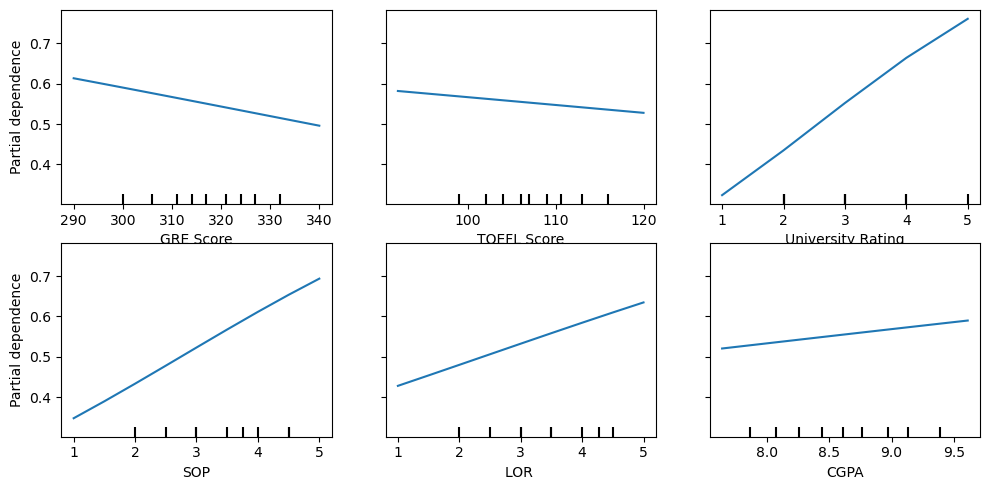

In [117]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

PartialDependenceDisplay.from_estimator(m_sat, X, X.columns, random_state=37, ax=ax, n_jobs=-1)

fig.tight_layout()

### PDP, AUC-ROC + AUC-PR best model

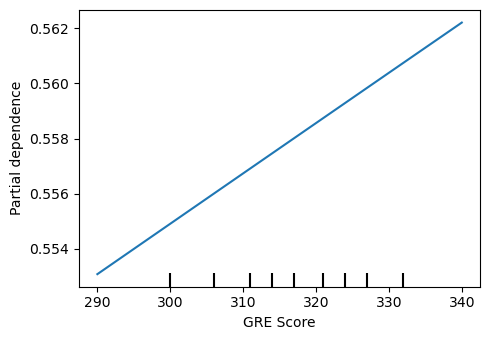

In [104]:
fig, ax = plt.subplots(figsize=(5, 3.5))

PartialDependenceDisplay.from_estimator(m_aps, X[['GRE Score']], ['GRE Score'], random_state=37, ax=ax, n_jobs=-1)

fig.tight_layout()

### PDP, BSS best model

Note that `CPGA` looks curvilinear.

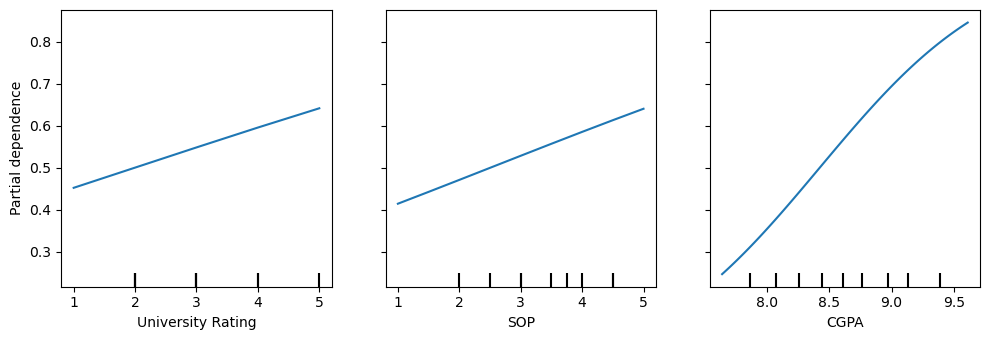

In [107]:
fig, ax = plt.subplots(figsize=(10, 3.5))

PartialDependenceDisplay.from_estimator(m_bss, X[['University Rating', 'SOP', 'CGPA']], ['University Rating', 'SOP', 'CGPA'], random_state=37, ax=ax, n_jobs=-1)

fig.tight_layout()

### PDP, LSS best model

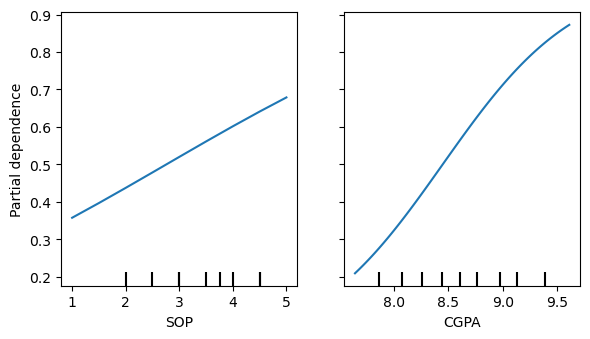

In [109]:
fig, ax = plt.subplots(figsize=(6, 3.5))

PartialDependenceDisplay.from_estimator(m_lss, X[['SOP', 'CGPA']], ['SOP', 'CGPA'], random_state=37, ax=ax, n_jobs=-1)

fig.tight_layout()

## Box plots

The box plots of each feature by `y` (research) shows that students who have done research have higher values across all features.

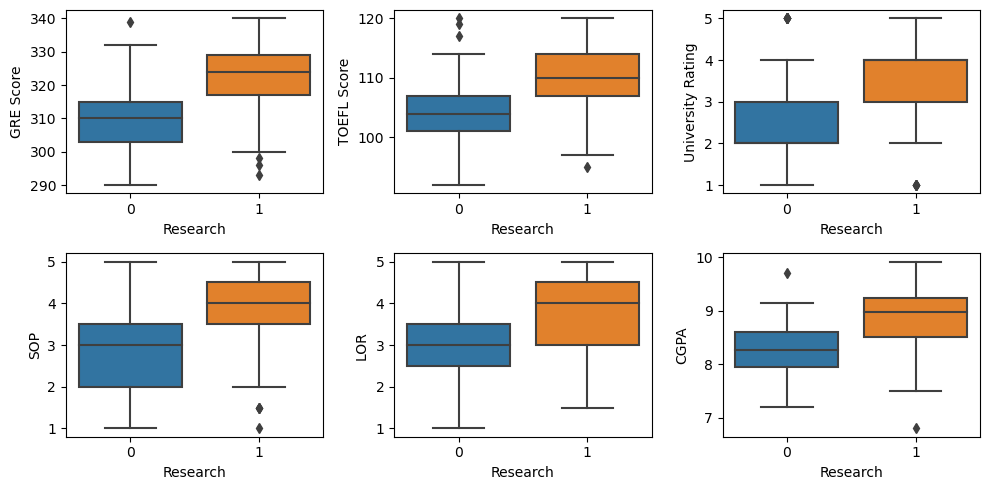

In [115]:
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for c, ax in zip(X.columns, np.ravel(axes)):
    sns.boxplot(Xy, x='Research', y=c, ax=ax)
    
fig.tight_layout()

## Two-way PDPs

Let's look at some two-way PDP plots.

### Two-way PDP, saturated model

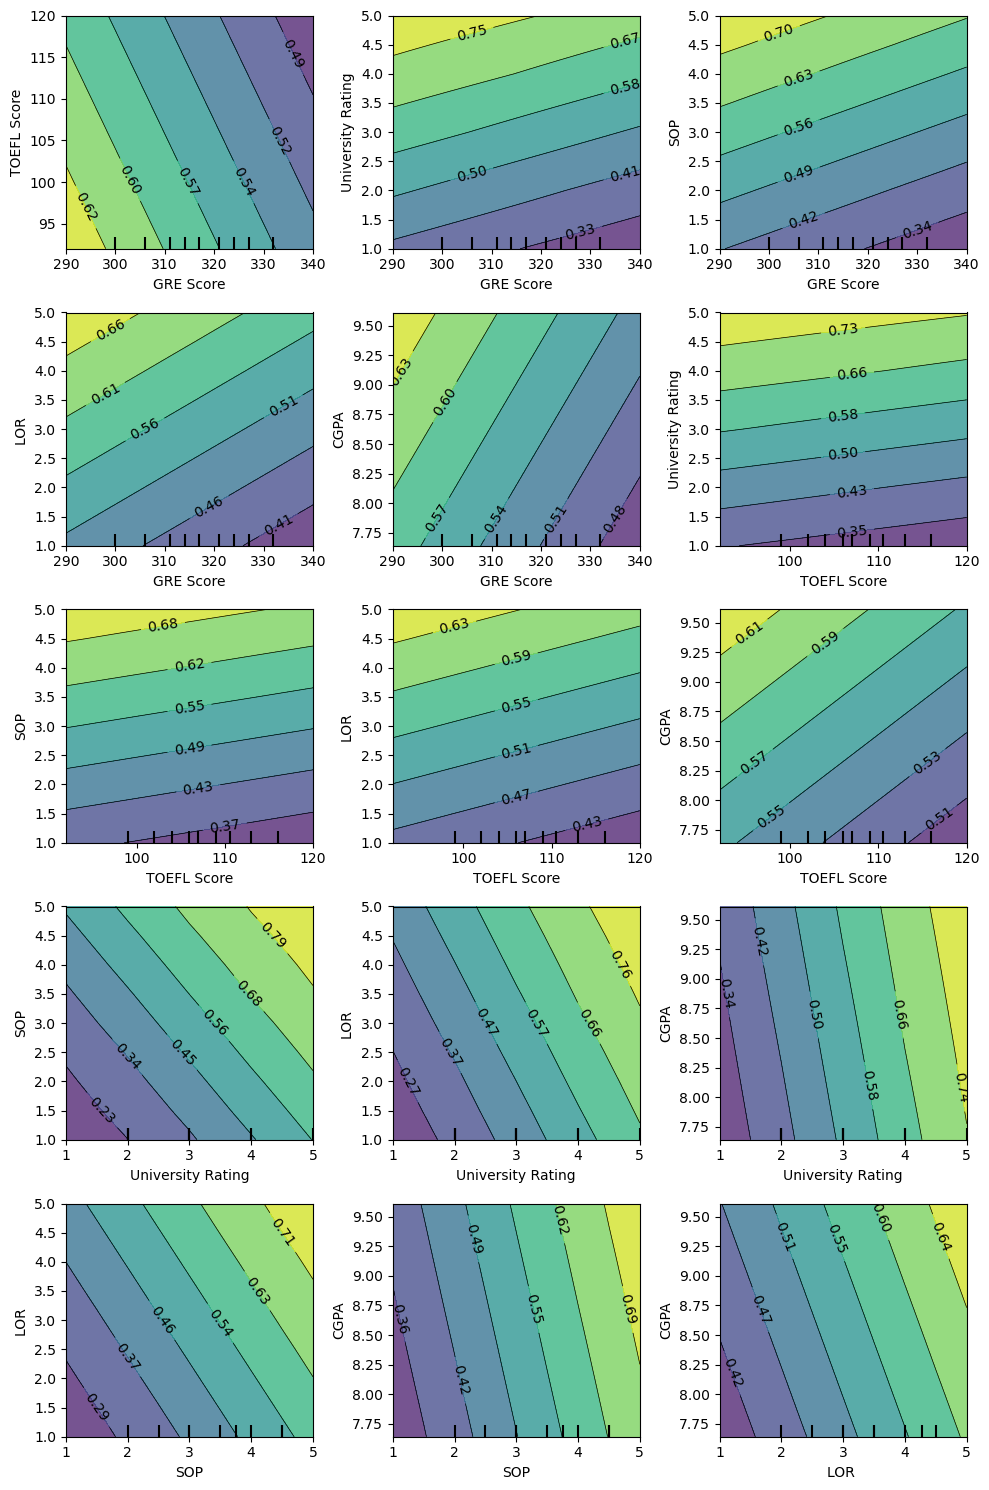

In [122]:
pairs = list(itertools.combinations(X.columns, 2))

fig, axes = plt.subplots(5, 3, figsize=(10, 15))

for p, ax in zip(pairs, np.ravel(axes)):
    PartialDependenceDisplay.from_estimator(m_sat, X, [p], random_state=37, ax=ax, n_jobs=-1)

fig.tight_layout()

### Two-way PDP, BSS best model

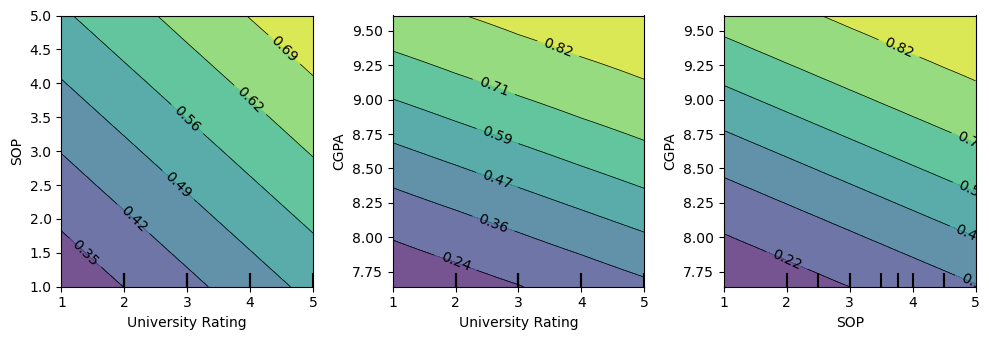

In [150]:
pairs = list(itertools.combinations(['University Rating', 'SOP', 'CGPA'], 2))

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

for p, ax in zip(pairs, np.ravel(axes)):
    PartialDependenceDisplay.from_estimator(m_bss, X[['University Rating', 'SOP', 'CGPA']], [p], random_state=37, ax=ax, n_jobs=-1)

fig.tight_layout()

## SHAP

Let's look at the following SHAP plots.

In [129]:
import shap

shap.initjs()

In [130]:
explainer = shap.Explainer(m_bss, X_tr[['University Rating', 'SOP', 'CGPA']])
shap_values = explainer(X_te[['University Rating', 'SOP', 'CGPA']])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


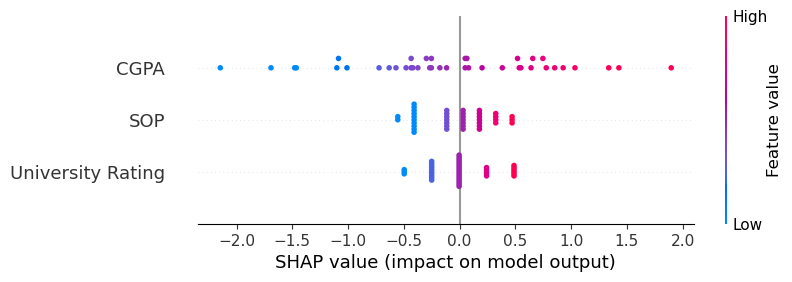

In [131]:
shap.plots.beeswarm(shap_values)

In [164]:
shap.plots.force(shap_values[0])

In [134]:
shap.plots.force(shap_values[1])

In [144]:
shap.plots.force(shap_values[2])

In [145]:
shap.plots.force(shap_values[3])

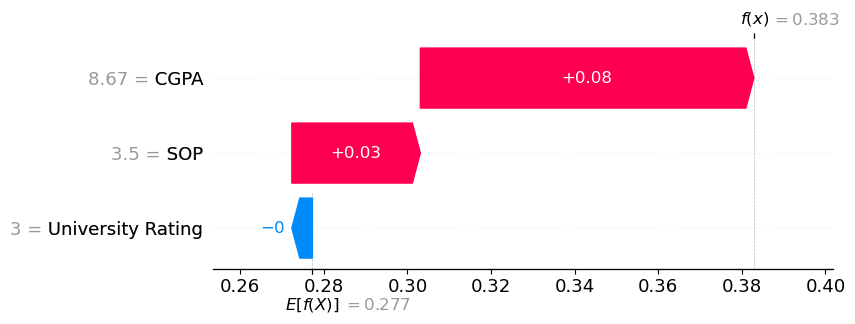

In [161]:
shap.plots.waterfall(shap_values[0])

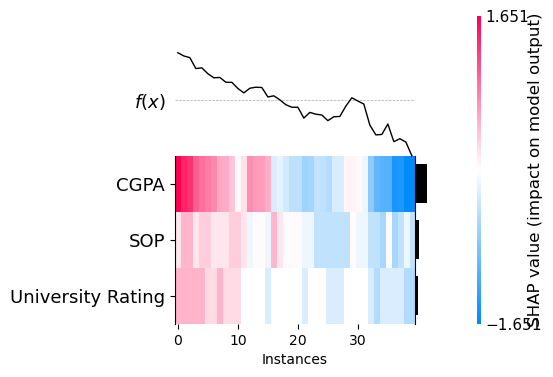

In [167]:
shap.plots.heatmap(shap_values)

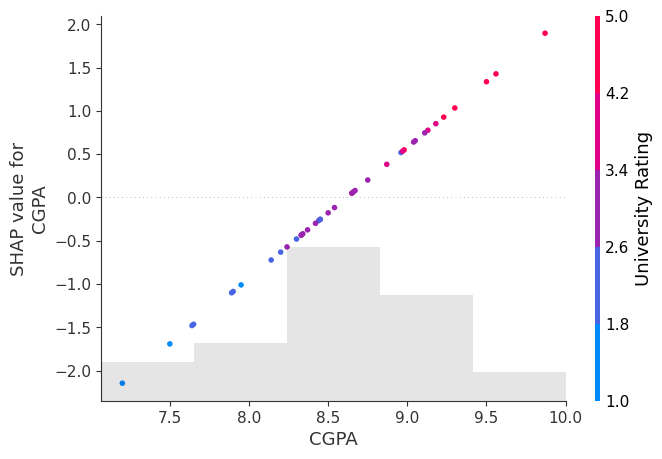

In [169]:
shap.plots.scatter(shap_values[:, 'CGPA'], color=shap_values)

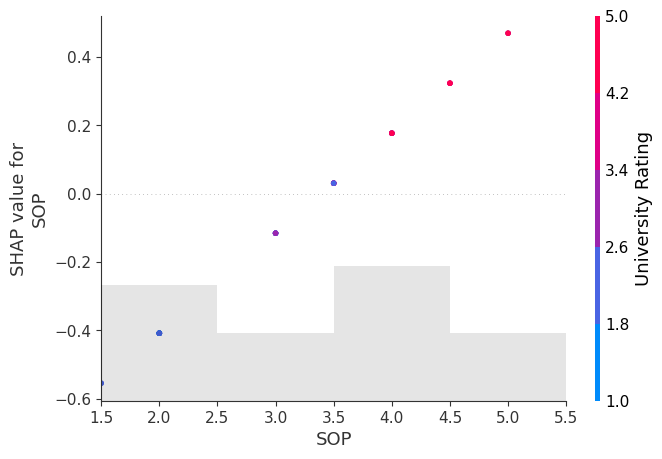

In [170]:
shap.plots.scatter(shap_values[:, 'SOP'], color=shap_values)

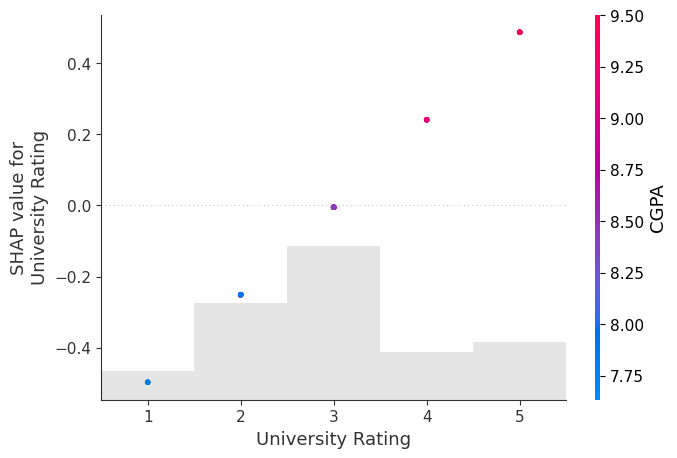

In [171]:
shap.plots.scatter(shap_values[:, 'University Rating'], color=shap_values)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


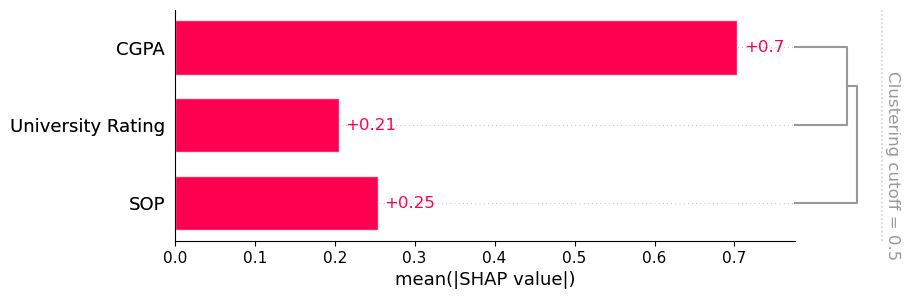

In [174]:
shap.plots.bar(shap_values, clustering=shap.utils.hclust(X_te[['University Rating', 'SOP', 'CGPA']], y_te))